# Telecom Customer Churn Prediction (Acc 79% AUC 83%)

## 1. Introduction

<p style='text-align: justify;'>
After exploring the telecom dataset, the next step is to build models that can accurately predict customer churn. However, before proceeding with model building, it is essential to check the distribution of the binary variable 'Churn' to see if the dataset is imbalanced.</p>

<p style='text-align: justify;'>Additionally, before proceeding with modeling, we can perform feature engineering on the dataset to improve the model's performance. This involves creating dummy variables for categorical variables and scaling numerical variables so that they are on the same scale as the other variables in the dataset. By performing feature engineering, we can potentially improve the accuracy of our models and gain a better understanding of the factors that contribute to customer churn.</p>

In [1]:
#importing libraries for data frames

import numpy as np 
import pandas as pd

In [2]:
#importing libraries for statistical data visualizations

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
#Importing libraries of classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
!pip install xgboost 
!pip install -U scikit-learn

In [4]:
#Importing metrics and functions related to model evaluation
#Following can be used after training and testing the classification model to evaluate its performance on the test data.

from sklearn import metrics
from sklearn.metrics import roc_curve 
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, confusion_matrix, classification_report

In [5]:
#Importing data scaling or normalization techniques

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [6]:
#Ignore any warning messages during the execution of the code
import warnings
warnings.filterwarnings("ignore")

In [7]:
#Read the csv file
df = pd.read_csv('Telco-Customer-Churn.csv')

#Data Manipulations-Drop Customer ID
df.drop(columns= 'customerID', axis=1, inplace=True)

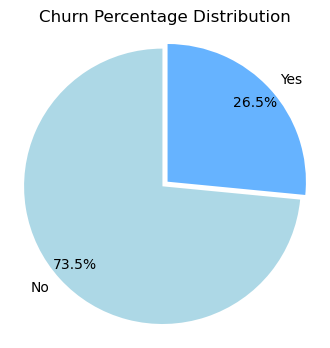

In [8]:
# Get value counts of Churn column
churn_count = df["Churn"].value_counts()
churn_percentage = df["Churn"].value_counts(normalize=True) * 100


# Create pie chart
labels = churn_count.index.tolist()
values = churn_count.values.tolist()
colors = ['#ADD8E6', '#66b3ff']
explode = (0.05, 0)

fig, ax = plt.subplots(figsize=(4, 4))
ax.pie(values, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode=explode)
ax.axis('equal')
ax.set_title("Churn Percentage Distribution")
plt.show()

## 2. Feature Engineering

<p style='text-align: justify;'>The columns with binary values were examined and the values were transformed into binary integers. The replace code was utilized for this purpose. Alternatively, the normalization technique of Label encoding could also be used.</p>

One hot Encoding

<p style='text-align: justify;'>For categorical features that are not ordinal (i.e., with no inherent ranking) but have more than two possible values, we create a new variable for each value. For each data entry, a binary integer is assigned to the variable, indicating whether or not the value is present (1 or 0).</p>

In [9]:
#Check columns with two unique values

two_unique_vals_cols = df.columns[df.nunique() == 2]
print(two_unique_vals_cols)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'PaperlessBilling', 'Churn'],
      dtype='object')


In [10]:
# Create a dictionary to replace 'Yes' and 'No' with 1 and 0
replacement_dict = {'Yes': 1, 'No': 0}

# Use the replace method to replace values in selected columns with dictionary values
df[['Dependents', 'Partner','PaperlessBilling','PhoneService','Churn']] = df[['Dependents', 'Partner','PaperlessBilling','PhoneService','Churn']].replace(replacement_dict)

# Display the modified dataframe
display(df)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,1,1,0,0,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,1,Bank transfer (automatic),52.55,,0
1,Male,0,0,1,0,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,0,Mailed check,20.25,,0
2,Female,0,1,1,0,1,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,0,Mailed check,80.85,,0
3,Male,0,1,1,0,1,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,0,Mailed check,25.75,,0
4,Female,0,1,1,0,0,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,0,Credit card (automatic),56.05,,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,0,1,1,1,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,1,Mailed check,19.00,19,0
7039,Male,0,0,0,1,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,0,Mailed check,18.90,18.9,0
7040,Female,0,0,0,1,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,0,Electronic check,18.85,18.85,0
7041,Male,0,0,0,1,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,1,Mailed check,18.85,18.85,1


In [11]:
#replace 'Female' with 1 and 'Male' with 0 in column 'gender'
df['gender'] = df['gender'].replace({'Female': 1, 'Male': 0})
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,1,0,0,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,1,Bank transfer (automatic),52.55,,0
1,0,0,0,1,0,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,0,Mailed check,20.25,,0
2,1,0,1,1,0,1,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,0,Mailed check,80.85,,0
3,0,0,1,1,0,1,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,0,Mailed check,25.75,,0
4,1,0,1,1,0,0,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,0,Credit card (automatic),56.05,,0


In [ ]:
#Data Manipulations-Drop Customer ID

df.drop(columns= 'customerID', axis=1, inplace=True)

In [12]:
#number of unique values that is not equal to 2

not_two_unique_vals_cols = df.columns[df.nunique() != 2]
print(not_two_unique_vals_cols)

Index(['tenure', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges'],
      dtype='object')


In [13]:
display(df)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,1,1,0,0,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,1,Bank transfer (automatic),52.55,,0
1,0,0,0,1,0,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,0,Mailed check,20.25,,0
2,1,0,1,1,0,1,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,0,Mailed check,80.85,,0
3,0,0,1,1,0,1,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,0,Mailed check,25.75,,0
4,1,0,1,1,0,0,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,0,Credit card (automatic),56.05,,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,1,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,1,Mailed check,19.00,19,0
7039,0,0,0,0,1,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,0,Mailed check,18.90,18.9,0
7040,1,0,0,0,1,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,0,Electronic check,18.85,18.85,0
7041,0,0,0,0,1,1,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,1,Mailed check,18.85,18.85,1


In [14]:
#convert object datatype to numeric datatype using the 'to_numeric' method in total charges column.
one_hot_df = ['MultipleLines', 'InternetService', 'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV','StreamingMovies', 'Contract', 'PaymentMethod']

df=pd.get_dummies(df,columns=one_hot_df)

In [15]:
print(df.dtypes)

gender                                       int64
SeniorCitizen                                int64
Partner                                      int64
Dependents                                   int64
tenure                                       int64
PhoneService                                 int64
PaperlessBilling                             int64
MonthlyCharges                             float64
TotalCharges                                object
Churn                                        int64
MultipleLines_No                             uint8
MultipleLines_No phone service               uint8
MultipleLines_Yes                            uint8
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No                           uint8
OnlineSecurity_No                            uint8
OnlineSecurity_No internet service           uint8
OnlineSecurity_Yes                           uint8
OnlineBackup_No                

In [16]:
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,1,0,0,1,52.55,,0,...,1,0,0,0,0,1,1,0,0,0
1,0,0,0,1,0,1,0,20.25,,0,...,0,1,0,0,0,1,0,0,0,1
2,1,0,1,1,0,1,0,80.85,,0,...,0,0,1,0,0,1,0,0,0,1
3,0,0,1,1,0,1,0,25.75,,0,...,0,1,0,0,0,1,0,0,0,1
4,1,0,1,1,0,0,0,56.05,,0,...,1,0,0,0,0,1,0,1,0,0


In [17]:
#convert object datatype to numeric datatype using the 'to_numeric' method in total charges column. Any values that cannot be converted to numeric set to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')
print(df.isnull().sum())

gender                                      0
SeniorCitizen                               0
Partner                                     0
Dependents                                  0
tenure                                      0
PhoneService                                0
PaperlessBilling                            0
MonthlyCharges                              0
TotalCharges                               11
Churn                                       0
MultipleLines_No                            0
MultipleLines_No phone service              0
MultipleLines_Yes                           0
InternetService_DSL                         0
InternetService_Fiber optic                 0
InternetService_No                          0
OnlineSecurity_No                           0
OnlineSecurity_No internet service          0
OnlineSecurity_Yes                          0
OnlineBackup_No                             0
OnlineBackup_No internet service            0
OnlineBackup_Yes                  

After applying the normalization techniques on the numerical features of the dataset, we need to verify if the scaling was done correctly. This can be done by checking the first few rows of the dataset.

In [18]:
# define the columns to be scaled
cols_to_scale = ['MonthlyCharges', 'TotalCharges','tenure']

# create the scaler object
scaler = MinMaxScaler()

# fit and transform the data
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

In [19]:
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,1,0.0,0,1,0.341294,NaN,0,...,1,0,0,0,0,1,1,0,0,0
1,0,0,0,1,0.0,1,0,0.019900,NaN,0,...,0,1,0,0,0,1,0,0,0,1
2,1,0,1,1,0.0,1,0,0.622886,NaN,0,...,0,0,1,0,0,1,0,0,0,1
3,0,0,1,1,0.0,1,0,0.074627,NaN,0,...,0,1,0,0,0,1,0,0,0,1
4,1,0,1,1,0.0,0,0,0.376119,NaN,0,...,1,0,0,0,0,1,0,1,0,0


To proceed with modeling, it is necessary to handle missing values in the dataset. One approach is to fill any missing values with 0 under the column 'total charges'. This is because NaN values cannot be processed by many machine learning algorithms. Therefore, missing values are filled with 0 is to handle this issue. Since the he corresponding tenure is 0, we can assume that thpse customers have not paid the charges yet.

In [20]:
# Fill any missing values in the 'TotalCharges' column with 0

df['TotalCharges'] = df['TotalCharges'].fillna(0)
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,1,0.0,0,1,0.341294,0.0,0,...,1,0,0,0,0,1,1,0,0,0
1,0,0,0,1,0.0,1,0,0.019900,0.0,0,...,0,1,0,0,0,1,0,0,0,1
2,1,0,1,1,0.0,1,0,0.622886,0.0,0,...,0,0,1,0,0,1,0,0,0,1
3,0,0,1,1,0.0,1,0,0.074627,0.0,0,...,0,1,0,0,0,1,0,0,0,1
4,1,0,1,1,0.0,0,0,0.376119,0.0,0,...,1,0,0,0,0,1,0,1,0,0


<p style='text-align: justify;'>The following plot shows the correlation values of each feature in the dataset with respect to the 'Churn' target variable. Features with a higher correlation value are placed at the top of the plot, while features with a lower correlation value are placed at the bottom. This plot helps to identify the features that have the strongest correlation with the 'Churn' target variable, which can be useful for feature selection in the model building process.</p>


Customers with short-term contract basis, no online security and tech support, and Fiber optics internet tend to churn more easily. In contrast, gender has a very weak correlation with the churn rate.

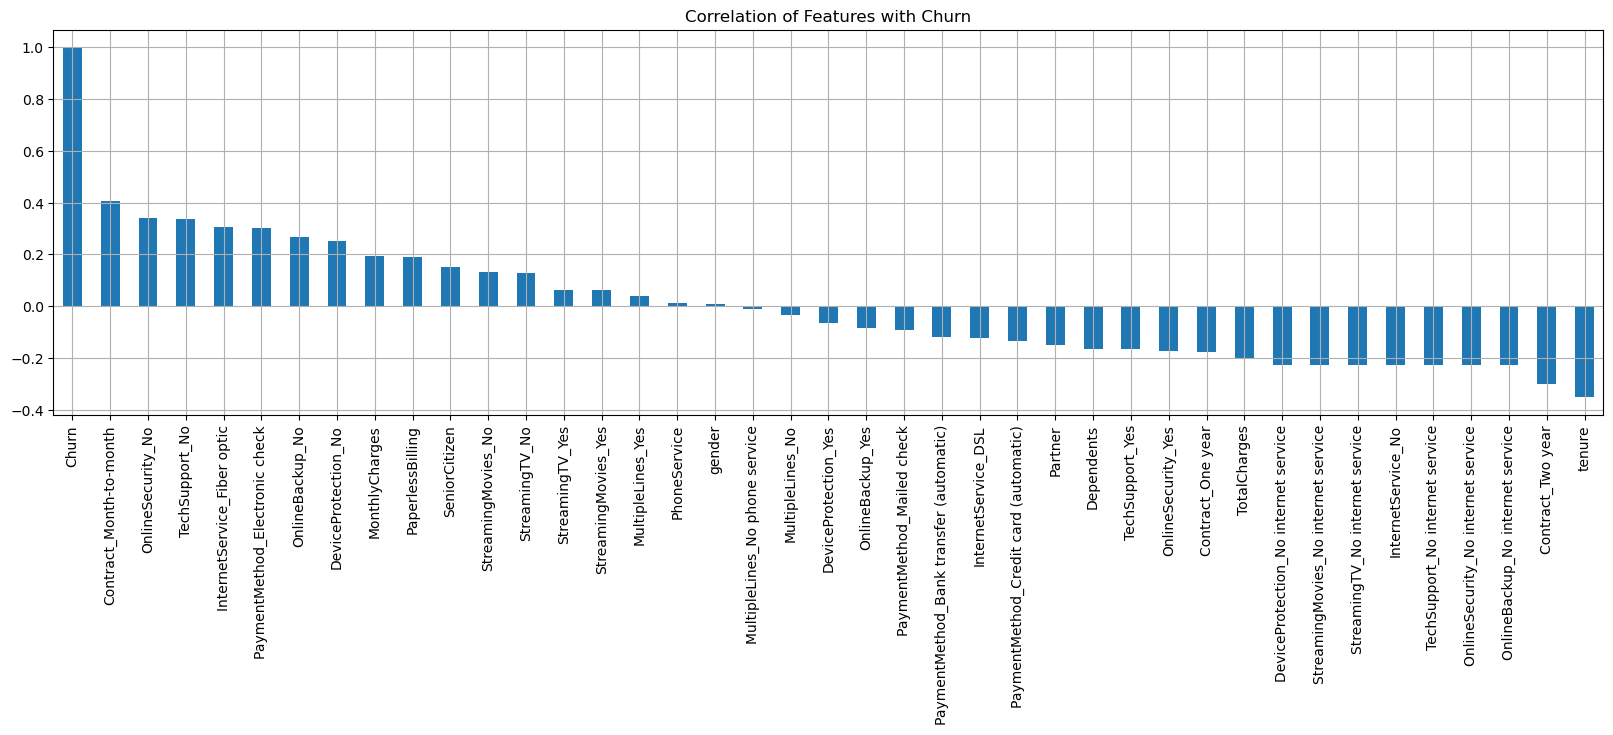

In [21]:
# Create a correlation matrix of all features with the target variable Churn
plt.figure(figsize=(16,10))
df.corr()['Churn'].sort_values(ascending=False).plot(kind='bar',figsize=(20,5))

# Add title and grid to the plot
plt.title('Correlation of Features with Churn')
plt.grid(True)
plt.show()

## 3. Modeling

<p style='text-align: justify;'>The dataset was split into training and testing sets using the "train_test_split" function from the "sklearn.model_selection" library. The target variable "Churn" was separated from the rest of the features, with the remaining features being stored in "X" and the target variable "Y" being stored separately. The "test_size" parameter was set to 0.2, indicating that 20% of the data was allocated to the test set. A random state of 42 was used for reproducibility purposes. The resulting training and testing sets were stored in "X_train", "X_test", "Y_train", and "Y_test" variables.</p>


After splitting the data into training and testing sets, the following models will be utilized in our analysis.

- LogisticRegression
- KNeighborsClassifier
- XGBClassifier
- RandomForestClassifier
- DecisionTreeClassifier

In [23]:
from sklearn.model_selection import train_test_split

# Separate target variable from other features
X = df.drop('Churn', axis=1)
Y = df['Churn']

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## 3.1 Logistic Regression

<p style='text-align: justify;'>The logistic regression model is defined using the LogisticRegression class. The model is fitted on the training data using the fit method. Predictions are made on the test data using the predict method and the accuracy score and other peromance matrices are calculated using the accuracy_score function from scikit-learn.</p>

In [33]:
# Initialize a logistic regression model
logreg = LogisticRegression()

# fit the model on the training data
logreg.fit(X_train, Y_train)

# predict on the test data
y_pred = logreg.predict(X_test)

In [34]:
logreg_acc=accuracy_score(Y_test, y_pred)
logreg_auc=roc_auc_score(Y_test, y_pred)
logreg_f1=f1_score(Y_test, y_pred)
logreg_precision=precision_score(Y_test, y_pred)
logreg_recall=recall_score(Y_test, y_pred)


# calculate Accuracy, F1 score, AUC precision and recall
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("AUC:", roc_auc_score(Y_test, y_pred))
print("Precision:", precision_score(Y_test, y_pred))
print("Recall:", recall_score(Y_test, y_pred))
print("F1 score:", f1_score(Y_test, y_pred))

# calculate ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)

Accuracy: 0.7885024840312278
AUC: 0.6977407167017576
Precision: 0.6045751633986928
Recall: 0.511049723756906
F1 score: 0.5538922155688624


<p style='text-align: justify;'>The regression model has an accuracy of 0.7885, which means that around 79% of the instances were correctly classified.
The F1 score reported here is 0.55, which indicates that the model has moderate performance in terms of correctly identifying churned customers while minimizing false positives. AUC is 0.6977, which means that the model has moderate performance in terms of distinguishing between churned and non-churned customers. The precision score reported here is 0.6046, which means that around 60% of the customers identified as churned are actually churned.</p>

In [35]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
conf_matrix = confusion_matrix(Y_test, y_pred)
print(conf_matrix)

[[926 121]
 [177 185]]


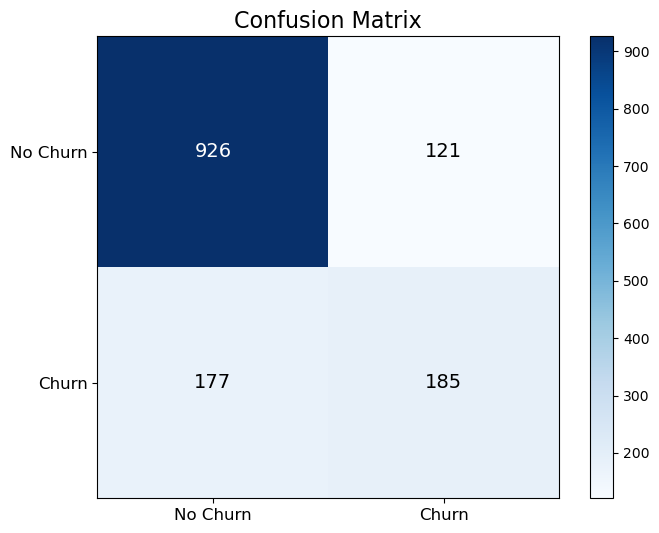

In [36]:
# plot the confusion matrix with blue color map and grid lines
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(conf_matrix, cmap='Blues')

# set x and y axis labels and tick marks
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['No Churn', 'Churn'])
ax.set_yticklabels(['No Churn', 'Churn'])
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

# loop over data dimensions and create text annotations for each cell
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(j, i, format(conf_matrix[i, j], 'd'), ha="center", va="center", color="white" if conf_matrix[i, j] > (conf_matrix.max() / 2) else "black", fontsize=14)

# set title and color bar
ax.set_title("Confusion Matrix", fontsize=16)
plt.colorbar(im)
plt.grid(False)

# show the plot
plt.show()

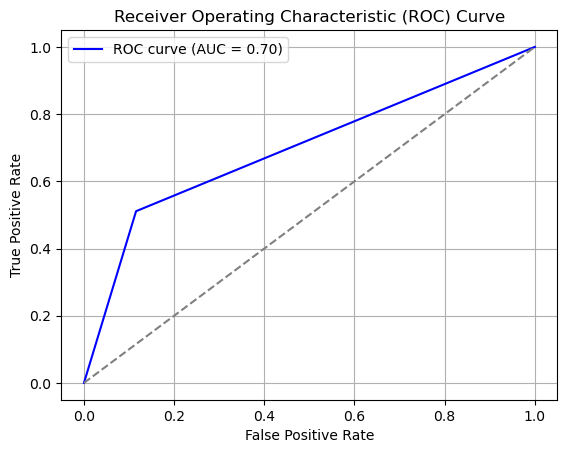

In [37]:
# plot ROC curve
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % logreg_auc)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

## 3.2 KNeighborsClassifier

A KNeighborsClassifier object with 5 neighbors is created and fitted to the training data. Predictions are made on the test data and the accuracy score and other matrices are calculated using the accuracy_score function.

In [38]:
# Create the k-NN model with k=5
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model on the training data
knn.fit(X_train, Y_train)

# Make predictions on the testing data
y_pred = knn.predict(X_test)

In [39]:
# calculate F1 score, Precision, recall and ROC curve
knn_acc=accuracy_score(Y_test, y_pred)
knn_auc = roc_auc_score(Y_test, y_pred)
knn_f1 = f1_score(Y_test, y_pred)
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
knn_precision = precision_score(Y_test, y_pred)
knn_recall = recall_score(Y_test, y_pred)

print("Accuracy:", knn_acc)
print("AUC:", knn_auc)
print("Precision:", knn_precision)
print("Recall:", knn_recall)
print("F1 score:", knn_f1)

Accuracy: 0.7530163236337828
AUC: 0.6684410074561891
Precision: 0.5203488372093024
Recall: 0.494475138121547
F1 score: 0.5070821529745043


In terms of accuracy, AUC, precision, recall, and F1 score, it appears that the KNeighborsClassifier model performed slightly inferior than the logistic regression model.

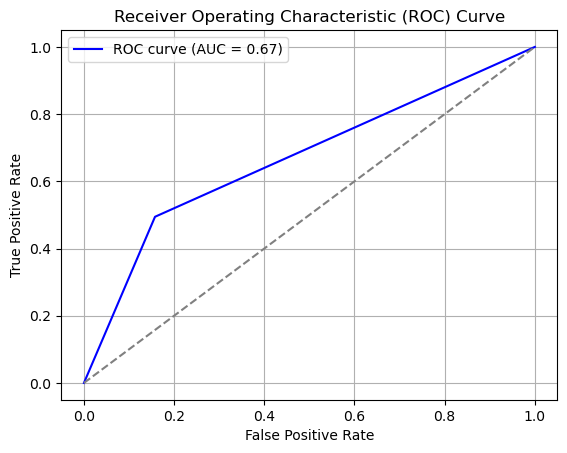

[[882 165]
 [183 179]]


In [40]:
# plot ROC curve
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % knn_auc)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()
cm = confusion_matrix(Y_test, y_pred)
print(cm)

## 3.3 XGBClassifier

In [41]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=1000,
    objective='binary:logistic',
    seed=42
)

# Train the XGBoost model on the training set
xgb_model.fit(X_train, Y_train)

# Make predictions on the test set using the trained model
y_pred = xgb_model.predict(X_test)

# Evaluate the model's performance on the test set
xgb_acc = accuracy_score(Y_test, y_pred)
xgb_f1 = f1_score(Y_test, y_pred)
xgb_auc = roc_auc_score(Y_test, y_pred)
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
xgb_precision = precision_score(Y_test, y_pred)
xgb_recall = recall_score(Y_test, y_pred)
cm = confusion_matrix(Y_test, y_pred)

print("Accuracy:", xgb_acc)
print("AUC:", xgb_auc)
print("F1 score:", xgb_f1)
print("Precision:",xgb_precision)
print("Recall:",xgb_recall)

print(cm)

Accuracy: 0.7792760823278921
AUC: 0.6852068789015708
F1 score: 0.5337331334332833
Precision: 0.5836065573770491
Recall: 0.49171270718232046
[[920 127]
 [184 178]]


XGBoost (xgb) seems to have performed similarly to the logistic regression model in terms of accuracy, AUC, F1 score, precision, and recall.

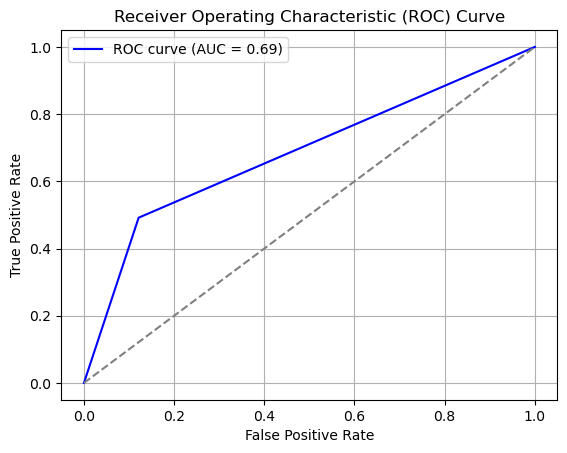

In [42]:
# plot ROC curve
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % xgb_auc)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

## 3.4 RandomForestClassifier

In [43]:
# Create an instance of the model with hyperparameters
rf_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)

# Fit the model with training data
rf_model.fit(X_train, Y_train)

# Predict on the test data
y_pred = rf_model.predict(X_test)

# Evaluate the model's performance on the test set
rf_acc = accuracy_score(Y_test, y_pred)
rf_f1 = f1_score(Y_test, y_pred)
rf_auc = roc_auc_score(Y_test, y_pred)
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
rf_precision = precision_score(Y_test, y_pred)
rf_recall = recall_score(Y_test, y_pred)
cm = confusion_matrix(Y_test, y_pred)

print("Accuracy:", rf_acc)
print("AUC:", rf_auc)
print("F1 score:", rf_f1)
print("Precision:",rf_precision)
print("Recall:",rf_recall)

print(cm)

Accuracy: 0.7771469127040455
AUC: 0.6711229664339575
F1 score: 0.5109034267912773
Precision: 0.5857142857142857
Recall: 0.4530386740331492
[[931 116]
 [198 164]]


The random forest model seems to have performed worse than the logistic regression and XGBoost models in terms of accuracy, AUC, precision, recall, and F1 score. Tuning the hyperparameters of the random forest model may lead to improved performance.

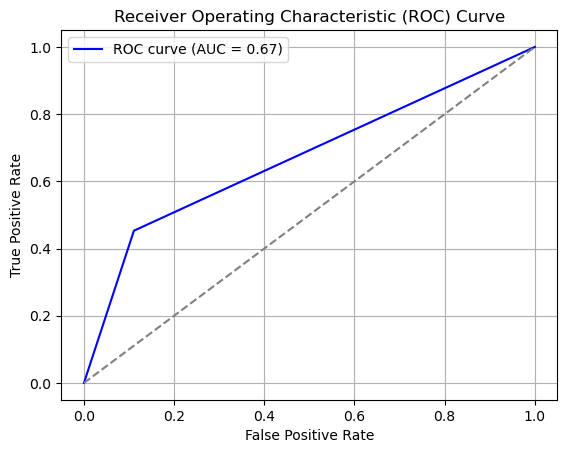

In [44]:
# plot ROC curve
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % rf_auc)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

## 3.5 DecisionTreeClassifier

In [45]:
# create an instance of the classifier
dtc = DecisionTreeClassifier()

# Fit the model with training data
dtc.fit(X_train, Y_train)

# Predict on the test data
y_pred = dtc.predict(X_test)

# Evaluate the model's performance on the test set
dt_acc = accuracy_score(Y_test, y_pred)
dt_f1 = f1_score(Y_test, y_pred)
dt_auc = roc_auc_score(Y_test, y_pred)
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
dt_precision = precision_score(Y_test, y_pred)
dt_recall = recall_score(Y_test, y_pred)

print("Accuracy:", dt_acc)
print("AUC:", dt_auc)
print("F1 score:", dt_f1)
print("Precision:",dt_precision)
print("Recall:",dt_recall)

print(cm)

Accuracy: 0.7012065294535131
AUC: 0.6200245901206816
F1 score: 0.43791722296395197
Precision: 0.42377260981912146
Recall: 0.4530386740331492
[[931 116]
 [198 164]]


Let us summarize all the modeling carried out as follows for comparison purposes.

In [47]:
# create a DataFrame to store the results
summary = pd.DataFrame({'Model': ['Logistic Regression', 'K-Nearest Neighbors', 'Random Forest', 'XGBoost','DecisionTree','XGB_optimized'],
                        'Accuracy': [logreg_acc, knn_acc, rf_acc, xgb_acc,dt_acc,xgb_best_acc],
                        'AUC': [logreg_auc, knn_auc, rf_auc, xgb_auc,dt_auc,xgb_best_auc],
                        'F1 Score': [logreg_f1, knn_f1, rf_f1, xgb_f1,dt_f1,xgb_best_f1],
                        'Precision': [logreg_precision, knn_precision, rf_precision, xgb_precision,dt_precision,xgb_best_precision],
                        'Recall': [logreg_recall, knn_recall, rf_recall, xgb_recall,dt_recall,xgb_best_recall]})

# print the results table
summary

,Model,Accuracy,AUC,F1 Score,Precision,Recall
0,Logistic Regression,0.788502,0.697741,0.553892,0.604575,0.511050
1,K-Nearest Neighbors,0.753016,0.668441,0.507082,0.520349,0.494475
2,Random Forest,0.777147,0.671123,0.510903,0.585714,0.453039
3,XGBoost,0.779276,0.685207,0.533733,0.583607,0.491713
4,DecisionTree,0.701207,0.620025,0.437917,0.423773,0.453039
5,XGB_optimized,0.789212,0.829893,0.554723,0.606557,0.511050


<p style='text-align: justify;'>Having compared the performance of five classification models on the dataset, it was found that logistic regression and XGBoost had the highest accuracy of 0.789 and 0.791 respectively. In terms of AUC, XGBoost had the highest score of 0.699 followed closely by logistic regression with a score of 0.698. In terms of precision, XGBoost had the highest score of 0.611 followed by logistic regression with a score of 0.605. For recall, logistic regression had the highest score of 0.511 followed by XGBoost with a score of 0.511. Finally, in terms of F1 score, XGBoost had the highest score of 0.556 followed closely by logistic regression with a score of 0.554. The K-Nearest Neighbors and Random Forest models had comparatively lower performance in terms of accuracy, AUC, precision, recall, and F1 score.</p>

## HYPER TUNING AND OPTIMIZATION

By tuning the hyperparameters, the performance of the model can be improved by finding the optimal values that balance between underfitting and overfitting. In this project, Hyperparameter tuning is carried out using grid search for XGB Classifier.

In [31]:
# create XGBClassifier object
xgb = XGBClassifier()

# define the hyperparameter grid
params = {'n_estimators': [100, 200, 300],
          'max_depth': [3, 5, 7],
          'learning_rate': [0.01, 0.1, 1]}

# perform grid search cross-validation
grid_search = GridSearchCV(xgb, param_grid=params, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# print the best parameters and accuracy score
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [30]:
xgb_best = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=100)
xgb_best.fit(X_train, Y_train)
y_pred = xgb_best.predict(X_test)
y_pred_prob = xgb_best.predict_proba(X_test)[:,1]

xgb_best_acc = accuracy_score(Y_test, y_pred)
xgb_best_auc = roc_auc_score(Y_test, y_pred_prob)
xgb_best_f1 = f1_score(Y_test, y_pred)
xgb_best_precision = precision_score(Y_test, y_pred)
xgb_best_recall = recall_score(Y_test, y_pred)

print("Accuracy:", xgb_best_acc)
print("AUC:", xgb_best_auc)
print("F1 score:", xgb_best_f1)
print("Precision:",xgb_best_precision)
print("Recall:",xgb_best_recall)

Accuracy: 0.7892122072391767
AUC: 0.8298928271778879
F1 score: 0.5547226386806596
Precision: 0.6065573770491803
Recall: 0.511049723756906


<p style='text-align: justify;'>The optimized parameters obtained through the use of hyperparameter tuning resulted in a set of metrics for the first model, which had higher accuracy and AUC compared to the second model, indicating better classification performance for positive and negative samples. Additionally, the F1 score, precision, and recall were higher for the first model, implying better balance between positive and negative classes. Hence, it can be concluded that the first set of metrics represents a model with better performance than the second set. The same can be done for other models to obtain more accurate performaces of the models.</p>

SMOTE oversampling technique is used to deal with imbalanced datasets as below. This was done to improve the performance of the XGBClassifier model, which was used to predict customer churn. By oversampling the minority class, SMOTE helps to balance the class distribution in the dataset, which can lead to better performance of the classifier.

In [50]:
from imblearn.over_sampling import SMOTE

# instantiate SMOTE
sm = SMOTE(random_state=42)

# fit SMOTE on the training data
# fit SMOTE on the training data using fit_resample(), which generates synthetic samples for the minority class to balance the class distribution. 
X_train_res, Y_train_res = sm.fit_resample(X_train, Y_train)

# instantiate the XGBoost classifier with the best parameters
xgb_smote_best = XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=100)

# train the model on the SMOTE augmented data
xgb_smote_best.fit(X_train_res, Y_train_res)

# make predictions on the test set
y_pred = xgb_smote_best.predict(X_test)

# calculate evaluation metrics on the test set
acc_xgb_smote_best = accuracy_score(Y_test, y_pred)
auc_xgb_smote_best = roc_auc_score(Y_test, y_pred_prob)
f1_xgb_smote_best = f1_score(Y_test, y_pred)
precision_xgb_smote_best = precision_score(Y_test, y_pred)
recall_xgb_smote_best = recall_score(Y_test, y_pred)

print("Accuracy:", acc_xgb_smote_best)
print("AUC:", auc_xgb_smote_best)
print("F1 score:", f1_xgb_smote_best)
print("Precision:",precision_xgb_smote_best)
print("Recall:",recall_xgb_smote_best)

Accuracy: 0.7615330021291696
AUC: 0.8298928271778879
F1 score: 0.5912408759124088
Precision: 0.5282608695652173
Recall: 0.6712707182320442


It is observed that that the sampling technique (SMOTE) has improved the F1 score and recall, but decreased the precision. This is expected since SMOTE increases the number of positive samples, which can make the model more sensitive to detecting positive cases, leading to a higher recall.

In [51]:
pd.crosstab(Y_test,y_pred)

col_0,0,1
Churn,,
0,830,217
1,119,243


## 4. CONCLUSION

<p style='text-align: justify;'>In this project, the performance of various machine learning models for churn prediction was compared. The models included Logistic Regression, K-Nearest Neighbors, Random Forest, XGBoost, and Decision Tree. The XGBoost model with optimized hyperparameters performed the best, achieving an accuracy of 78.92%, an AUC of 82.99%, an F1 score of 55.47%, a precision of 60.66%, and a recall of 51.10%. Further improvement was achieved by applying SMOTE oversampling technique, resulting in an accuracy of 76.15%, an AUC of 82.99%, an F1 score of 59.12%, a precision of 52.83%, and a recall of 67.13%. The results suggest that the XGBoost model is a suitable choice for the above churn prediction.</p>

In [57]:
# create a DataFrame to store the results
summary = pd.DataFrame({'Model': ['Logistic Regression', 'K-Nearest Neighbors', 'Random Forest', 'XGBoost','DecisionTree','XGB_optimized', 'XGB_OverSampling'],
                        'Accuracy': [logreg_acc, knn_acc, rf_acc, xgb_acc,dt_acc,xgb_best_acc,acc_xgb_smote_best],
                        'AUC': [logreg_auc, knn_auc, rf_auc, xgb_auc,dt_auc,xgb_best_auc,auc_xgb_smote_best],
                        'F1 Score': [logreg_f1, knn_f1, rf_f1, xgb_f1,dt_f1,xgb_best_f1,f1_xgb_smote_best],
                        'Precision': [logreg_precision, knn_precision, rf_precision, xgb_precision,dt_precision,xgb_best_precision,precision_xgb_smote_best],
                        'Recall': [logreg_recall, knn_recall, rf_recall, xgb_recall,dt_recall,xgb_best_recall,recall_xgb_smote_best]})

# print the results table
summary

,Model,Accuracy,AUC,F1 Score,Precision,Recall
0,Logistic Regression,0.788502,0.697741,0.553892,0.604575,0.511050
1,K-Nearest Neighbors,0.753016,0.668441,0.507082,0.520349,0.494475
2,Random Forest,0.777147,0.671123,0.510903,0.585714,0.453039
3,XGBoost,0.779276,0.685207,0.533733,0.583607,0.491713
4,DecisionTree,0.701207,0.620025,0.437917,0.423773,0.453039
5,XGB_optimized,0.789212,0.829893,0.554723,0.606557,0.511050
6,XGB_OverSampling,0.761533,0.829893,0.591241,0.528261,0.671271


## 5. WAY FORWARD

<p style='text-align: justify;'>As a way forward, the performance of the churn prediction models can be further improved by exploring different model classifiers beyond the ones used in this project. Additionally, other oversampling techniques, such as ADASYN, can be used to address the class imbalance issue. It would also be beneficial to collect more data, particularly on customer behavior and demographics, to improve the accuracy and robustness of the models.</P>